In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import json
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
sys.path.append('/Applications/OpenFUSIONToolkit/python')
# tokamaker_python_path = os.getenv('OFT_ROOTPATH')
# if tokamaker_python_path is not None:
#     sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, read_eqdsk

In [3]:
with open('example/DIIID_geom.json','r') as fid:
    DIIID_geom = json.load(fid)

target_name = 'g192185.02440'
target_eq = read_eqdsk(f'gEQDSKs/{target_name}')
target_bndry = target_eq['rzout'].copy()

In [4]:
# Distance helper functions

from scipy.interpolate import interp1d
from scipy.spatial.distance import directed_hausdorff
from scipy.linalg import orthogonal_procrustes

def resample_curve(curve, num_points=200):
    """
    Resample a closed curve to have a specified number of points using interpolation.
    """
    t = np.linspace(0, 1, curve.shape[1])
    new_t = np.linspace(0, 1, num_points)
    interp_x = interp1d(t, curve[0, :], kind='cubic')
    interp_y = interp1d(t, curve[1, :], kind='cubic')
    return np.array([interp_x(new_t), interp_y(new_t)])

def simplified_procrustes(X, Y):
    """
    Compute the distance between two aligned and scaled shapes, preserving absolute positions.
    Assumes X and Y are already aligned and have the same length.
    Aggregate difference.
    """
    # Compute the sum of squared differences between corresponding points
    distance = np.sqrt(np.sum(np.sum((X - Y) ** 2, axis=0)))
    return distance

def hausdorff_distance(X, Y):
    """
    Calculate the Hausdorff distance between two sets of points.
    Worst-case outlier.
    """
    d1 = directed_hausdorff(X.T, Y.T)[0]
    d2 = directed_hausdorff(Y.T, X.T)[0]
    return max(d1, d2)

def pointwise_difference(X, Y):
    """
    Calculate the mean squared error between corresponding points. 
    Mean difference.
    """
    return np.mean(np.sum((X - Y) ** 2, axis=0))

def plot_curves(X, Y):
    """
    Plot two sets of coordinates representing curves.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(X[0, :], X[1, :], label='Curve 1', marker='o')
    plt.plot(Y[0, :], Y[1, :], label='Curve 2', marker='x')
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Comparison of Two Curves')
    plt.axis('equal')
    plt.grid(True)
    plt.show()

# ## Test
# curve1 = np.transpose(bndry)
# curve2 = np.transpose(target_bndry)

# # Resample the curves to have the same number of points
# curve1_resampled = resample_curve(curve1)
# curve2_resampled = resample_curve(curve2)

# # Calculate differences
# procrustes_diff = simplified_procrustes(curve1_resampled, curve2_resampled)
# hausdorff_diff = hausdorff_distance(curve1_resampled, curve2_resampled)
# mse_diff = pointwise_difference(curve1_resampled, curve2_resampled)

# # Display results
# print("Simplified Procrustes Distance:", procrustes_diff)
# print("Hausdorff Distance:", hausdorff_diff)
# print("Mean Squared Error (MSE):", mse_diff)

# # Plot the curves
# plot_curves(curve1_resampled, curve2_resampled)

In [5]:
# Assess the reslts 
results = {}
for eqdsk_name in [x for x in os.listdir('gEQDSKs') if 'n5' in x]:
    results[eqdsk_name] = {}
    eqdsk = read_eqdsk(f'gEQDSKs/{eqdsk_name}')
    bndry = results[eqdsk_name]['bndry'] = eqdsk['rzout'].copy()
    
    curve1 = np.transpose(bndry)
    curve2 = np.transpose(target_bndry)

    # Resample the curves to have the same number of points
    curve1_resampled = resample_curve(curve1)
    curve2_resampled = resample_curve(curve2)

    # Calculate differences
    results[eqdsk_name]['procrustes_diff'] = simplified_procrustes(curve1_resampled, curve2_resampled)
    results[eqdsk_name]['hausdorff_diff'] = hausdorff_distance(curve1_resampled, curve2_resampled)
    results[eqdsk_name]['pointwise_diff'] = pointwise_difference(curve1_resampled, curve2_resampled)

# Sort the results
bounds = {}
diffs = ['procrustes_diff', 'hausdorff_diff', 'pointwise_diff']
for diff in diffs:
    bounds[diff] = {}
    bounds[diff]['max'] = np.max([results[eqdsk_name][diff] for eqdsk_name in results.keys()])
    bounds[diff]['min'] = np.min([results[eqdsk_name][diff] for eqdsk_name in results.keys()])

In [50]:
# Get the coil data
from helper_functions import resize_polygon, place_points, update_boundary, plot_coil

lim = update_boundary(r0=1.69, z0=0, a0=0.67, kappa=2, delta=0.8, squar=0.15, npts=201)
coil_centers = resize_polygon(lim, 0.2)

coil_locs = {}
for eqdsk_name in results.keys():
    coil_locs[eqdsk_name] = {}
    distribution = [int(x) for x in eqdsk_name.split('_d')[1].split('-')]
    inds, locs = place_points(len(distribution)-1, coil_centers[:len(coil_centers)//2,:], distribution)
    for i in np.arange(locs.shape[0]):
        coil_locs[eqdsk_name][f'F{i}X'] = locs[i,0].copy()
        coil_locs[eqdsk_name][f'F{i}Y'] = locs[i,1].copy()

coil_names = np.unique([x[:2] for x in coil_locs[eqdsk_name].keys()])

coil_info = {}
for coil in coil_locs[eqdsk_name].keys():
    coil_info[coil] = np.array([coil_locs[eqdsk_name][coil] for eqdsk_name in results.keys()])

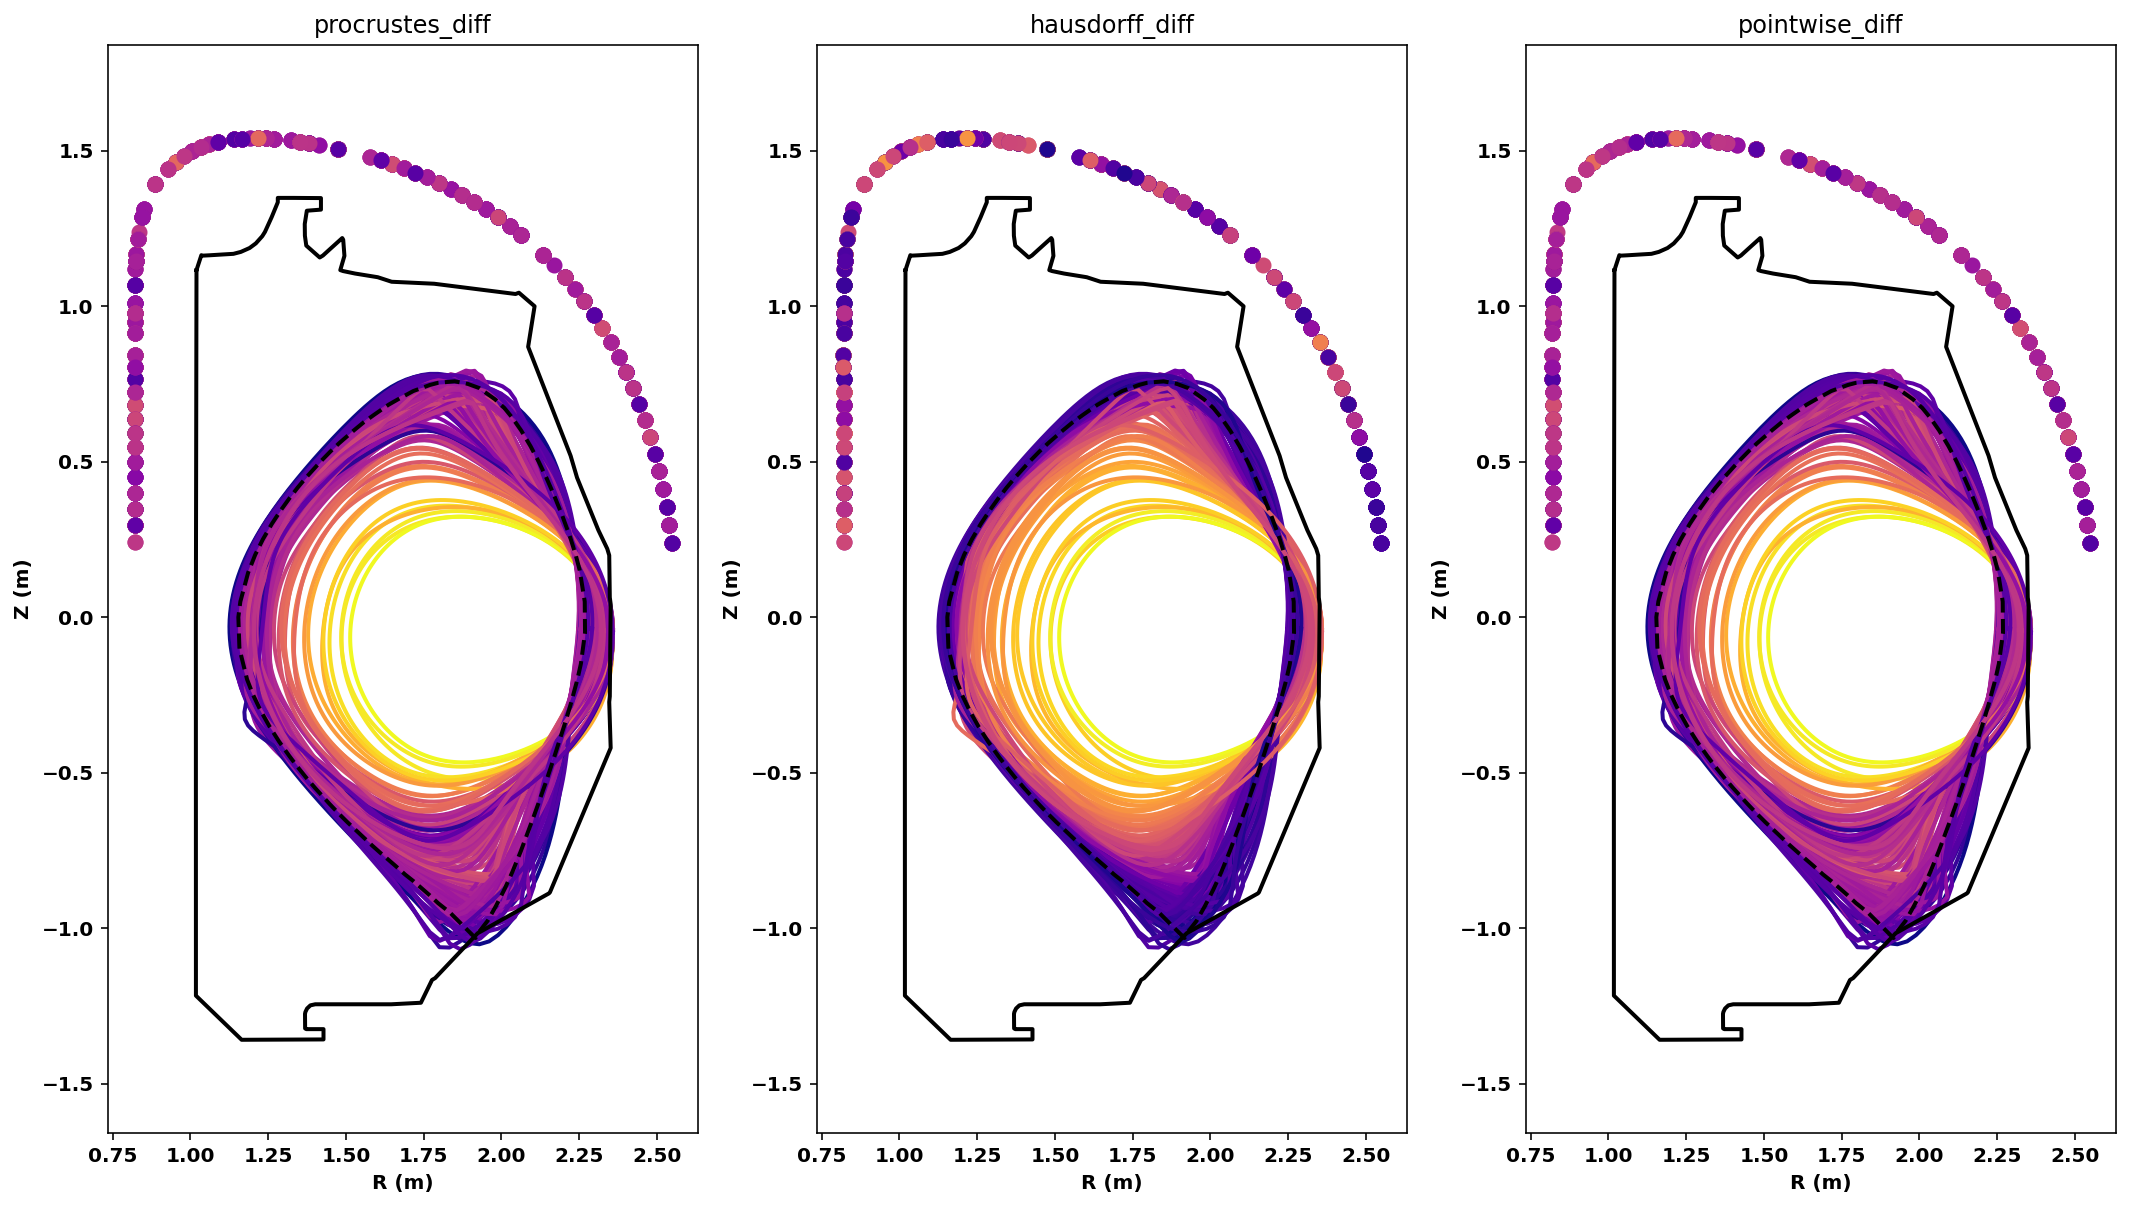

In [51]:
# Make the figure
plt.figure(figsize = (18,10))
axs = {}
for ax in [1,2,3]:
    axs[ax] = plt.subplot(1,3,ax)   
    axs[ax].axis('equal')

# Plot the results
cmap = plt.get_cmap('plasma')
cmapr = plt.get_cmap('plasma_r')
for eqdsk_name in results.keys():
    for ax, diff in enumerate(diffs):
        cind = (results[eqdsk_name][diff]-bounds[diff]['min']) / (bounds[diff]['max']-bounds[diff]['min'])
        if diff in ['procrustes_diff', 'pointwise_diff']:
            c = cmapr(cind)
        else:
            c = cmap(cind)

        # plot the boundary
        axs[ax+1].plot(results[eqdsk_name]['bndry'][:,0], results[eqdsk_name]['bndry'][:,1], c=c)

        # plot the coils
        for coil in coil_names:
            axs[ax+1].plot(coil_locs[eqdsk_name][f'{coil}X'], coil_locs[eqdsk_name][f'{coil}Y'], 'o', c=c)

for ax, diff in enumerate(diffs):
    # Plot the target
    axs[ax+1].plot(target_bndry[:,0], target_bndry[:,1], c='k', ls='--')

    # Plot the limiter
    lim = np.array(DIIID_geom['limiter'])
    axs[ax+1].plot(np.hstack((lim[:,0],lim[0,0])), np.hstack((lim[:,1],lim[0,1])), c='k')

    # Labels
    axs[ax+1].set_xlabel('R (m)')
    axs[ax+1].set_ylabel('Z (m)')
    axs[ax+1].set_title(diff)

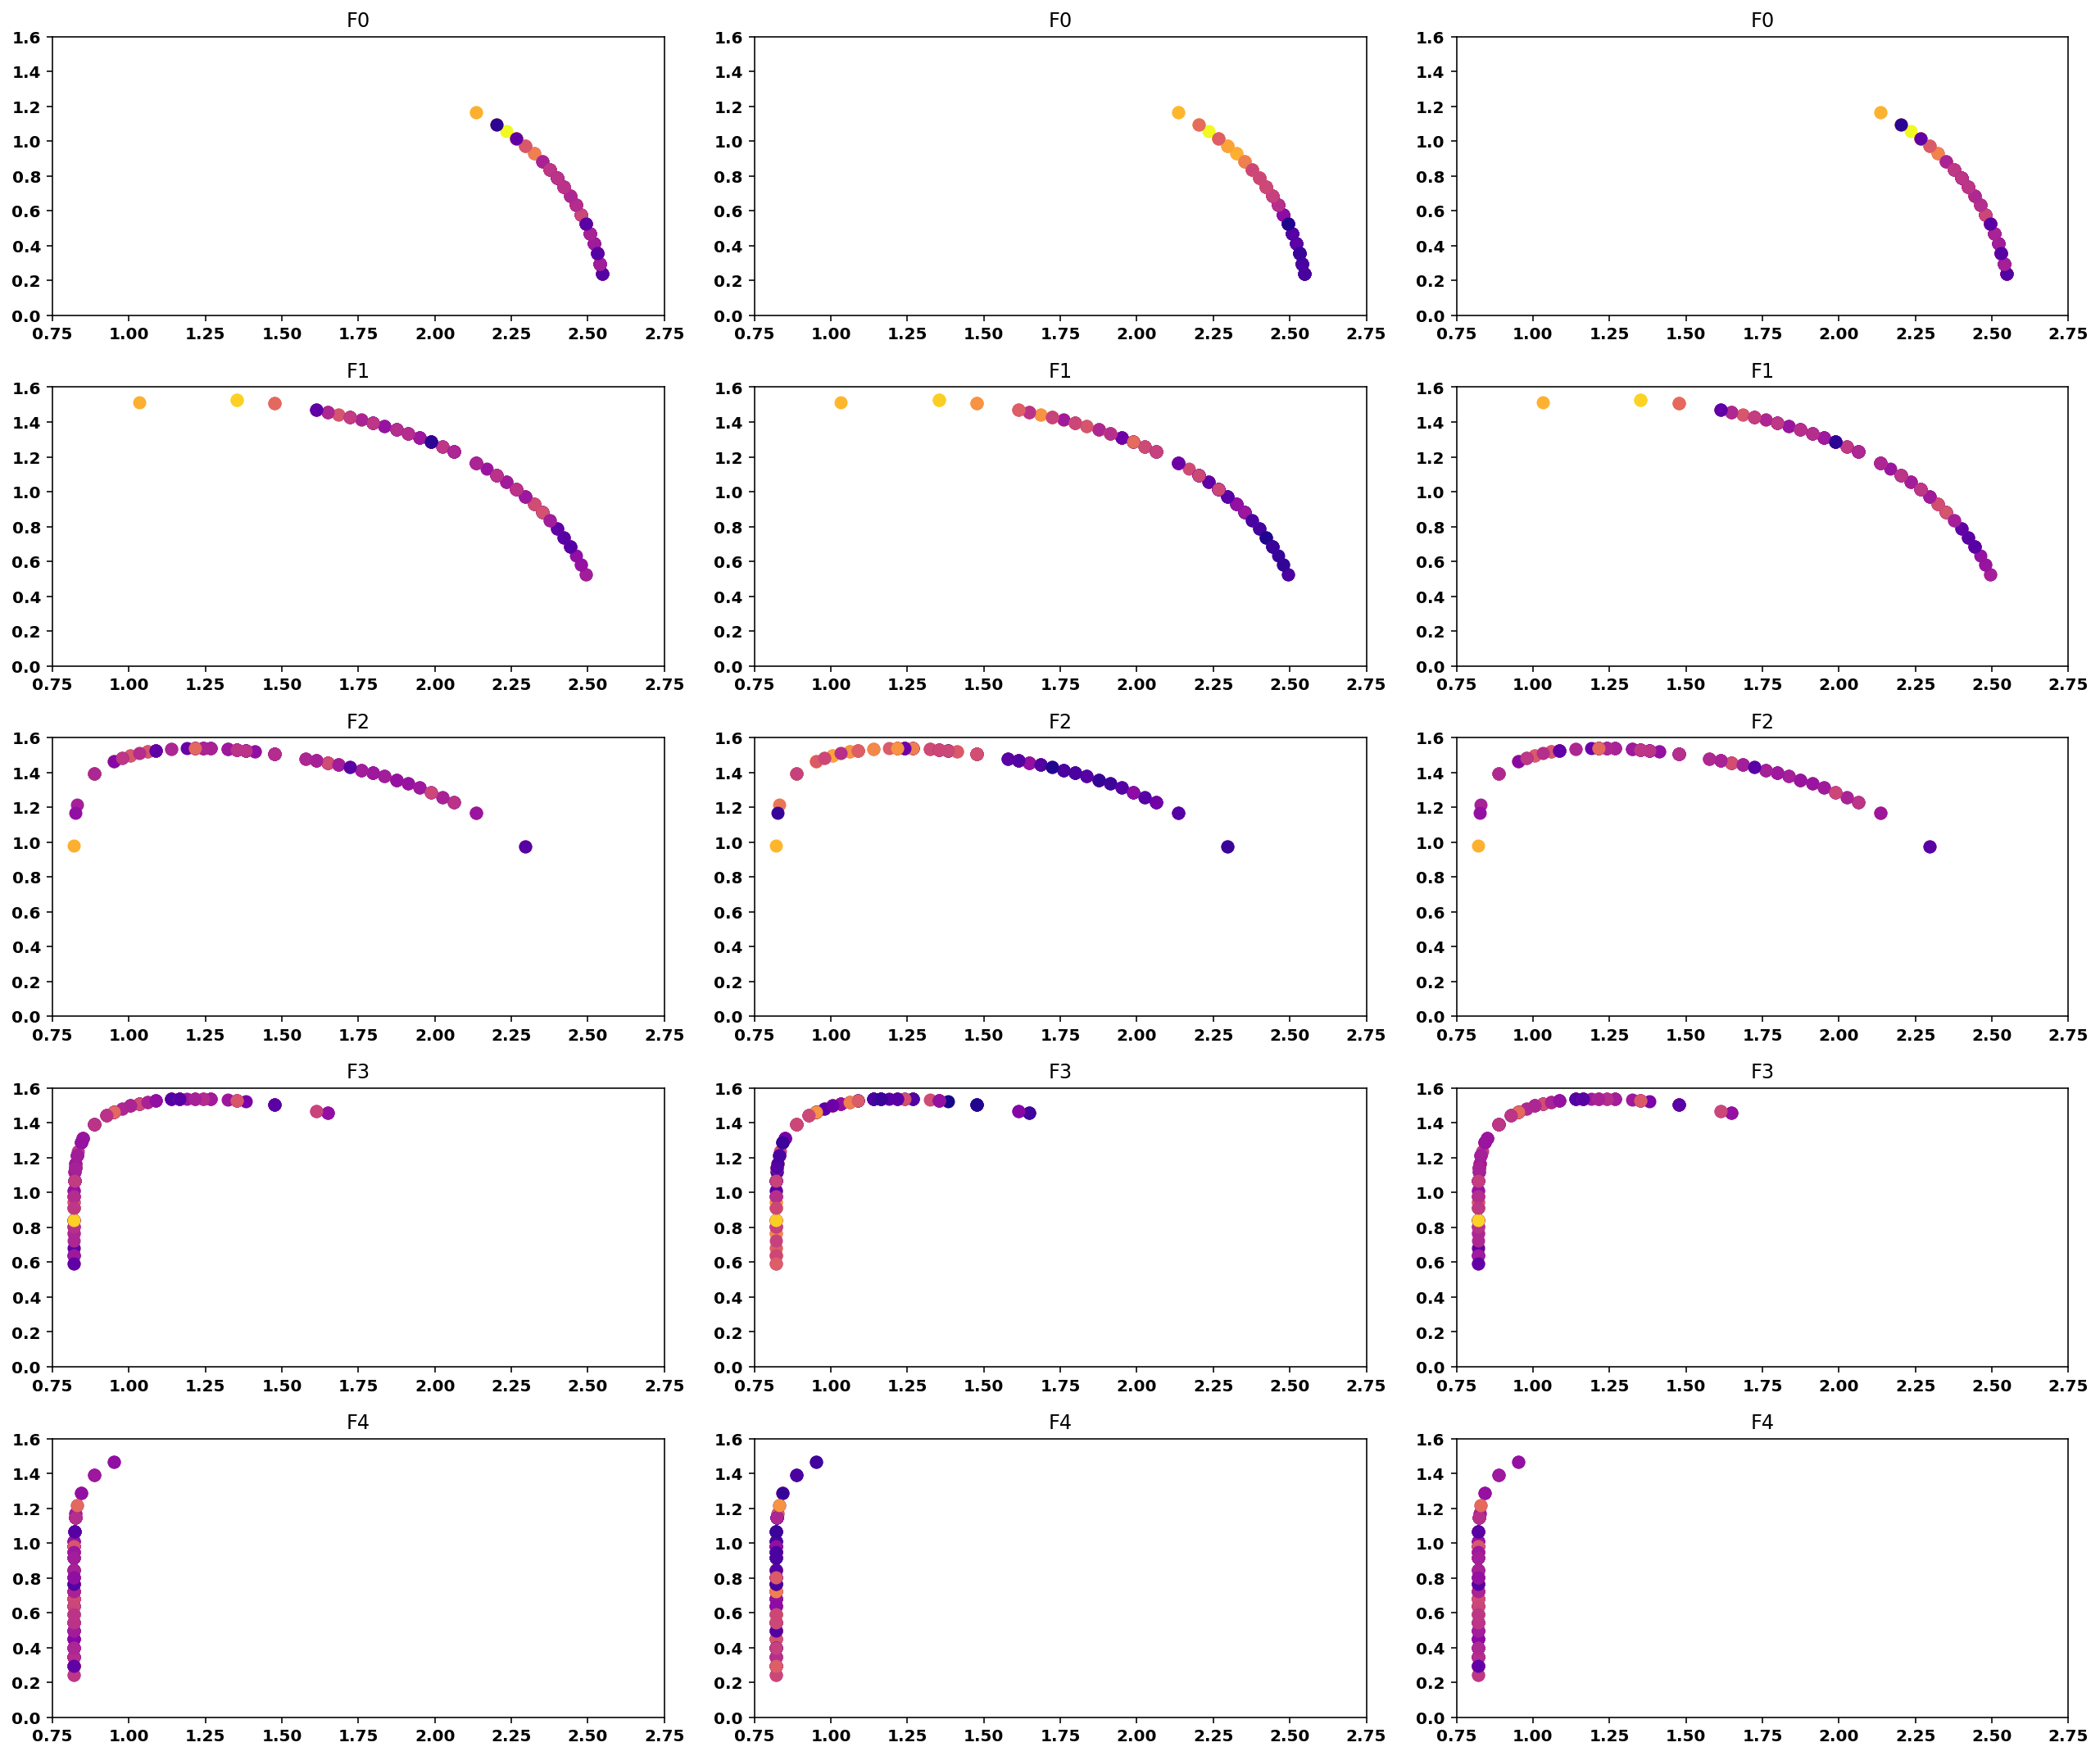

In [67]:
# Make the figure
plt.figure(figsize = (18,15))
axs = {}
ncols = len(diffs)
nrows = len(coil_names)
for i in np.arange(ncols):
    for j in np.arange(nrows):
        ax = (ncols*j) + i + 1
        axs[ax] = plt.subplot(nrows,ncols,ax)   
        axs[ax].set_title(f'F{j}')

for eqdsk_name in results.keys():
    for i, diff in enumerate(diffs):
        cind = (results[eqdsk_name][diff]-bounds[diff]['min']) / (bounds[diff]['max']-bounds[diff]['min'])
        if diff in ['procrustes_diff', 'pointwise_diff']:
            c = cmapr(cind)
        else:
            c = cmap(cind)

        # plot the coils
        for j, coil in enumerate(coil_names):
            ax = (ncols*j) + i + 1
            axs[ax].plot(coil_locs[eqdsk_name][f'F{j}X'], coil_locs[eqdsk_name][f'F{j}Y'], 'o', c=c)

for ax in axs.keys():
    axs[ax].set_xlim(0.75, 2.75)
    axs[ax].set_ylim(0, 1.6)
plt.tight_layout()